# ***Alexanda Apostolopoulou***
# ***1115201700005***
# *Project 3 in AI (II)* 

## Import some useful libraries

In [ ]:
import pandas as pd
import string
import os
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import urllib
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import time
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import folium
from itertools import cycle, islice
from pandas import options
import warnings
import pickle
import re
import nltk
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from matplotlib.pyplot import figure
from nltk.corpus import stopwords 
import nltk
from torchtext import data
from torchtext.vocab import Vectors, GloVe
import torch.nn.functional as F
from torch.autograd import Variable
import torchtext
from tqdm.notebook import tqdm

## ***Step 1***: Load the data of preprocessing Notebook


Here I have to mention that I load the half dataset (of 5000.000 tweets), since I want to save time for my research and because I didn't observe any improvement in the performance of my LSTM/GRU model when I load all the dataset.

The proprocess of the data remains exactly the same as in the first and the second project that I already done.

There are some notes and comments in the preprocessing notebook, in which I explain extensively what I have done.

In [ ]:
x_train_file = open('/content/drive/My Drive/X_train.pkl', 'rb')
X_train = pickle.load(x_train_file)

x_test_file = open('/content/drive/My Drive/X_test.pkl', 'rb')
X_test = pickle.load(x_test_file)

y_train_file = open('/content/drive/My Drive/Y_train.pkl', 'rb')
Y_train = pickle.load(y_train_file)

y_test_file = open('/content/drive/My Drive/Y_test.pkl', 'rb')
Y_test = pickle.load(y_test_file)

x_val_file = open('/content/drive/My Drive/X_val.pkl', 'rb')
X_val = pickle.load(x_val_file)

y_val_file = open('/content/drive/My Drive/Y_val.pkl', 'rb')
Y_val = pickle.load(y_val_file)

Here, as you can see, I concatenate all the X data with the Y data, in order to make it easy to use the Tabular Dataset and the Bucket Iterator.

In [ ]:
train = pd.concat([X_train, Y_train], axis=1)
print(train.shape)

valid = pd.concat([X_val, Y_val], axis=1)
print(valid.shape)

test = pd.concat([X_test, Y_test], axis=1)
print(test.shape)

(495012, 2)
(2488, 2)
(2500, 2)


I save the train, valid and test data in .csv files.

In [ ]:
train.to_csv("/content/drive/My Drive/torchtext_data/train.csv", index=False)
test.to_csv("/content/drive/My Drive/torchtext_data/test.csv", index=False)
valid.to_csv("/content/drive/My Drive/torchtext_data/valid.csv", index=False)

## ***Step 2***: Use Cuda/GPU


Here I use the GPU (whenever I can) that google colab offer to its users.

As in the other Projects, GPU is very important to run the notebook, since without it, it take several hours to run and see some results. The dataset is very big to have the ability to run with my CPU. 

In [ ]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## ***Step 3***: Prepare our data using TorchText TabularDataset and BucketIterator


Here, we want to tokenize the text using Torchtext and Spacy together. Spacy is a library that has been specifically built to take sentences in various languages and split them into different tokens.

So, I have created two field objects that later will be able to process/tokenize our text (tweets). The label field is a shallow wrapper around a standard field designed to hold labels for a classification task.

In [ ]:
# tokenizer = "spacy" uses spacy's tokenizer
TEXT = data.Field(sequential=True, tokenize="spacy", lower=True, batch_first=True)
LABEL = data.LabelField(dtype=torch.long, sequential=False)

Here I use the Torchtext **TabularDataset** function, which creates datasets from spreadsheet formats.

Calling the TabularDataset.splits returns a train, a validation and a test dataset with the respective data loaded into them, processed (tokenized) according to the fields I defined earlier.

In [ ]:
# loading train, test and validation data 
train_data, valid_data, test_data = data.TabularDataset.splits(
    path="/content/drive/My Drive/torchtext_data/", train="train.csv", 
    validation="valid.csv", test="test.csv",format="csv", skip_header=True, 
    fields=[('Text', TEXT), ('Label', LABEL)]
)

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 495012
Number of valid examples: 2488
Number of testing examples: 2500


After we have done with the TabularDataset.splits, we built the ***vocabularies***, in order to index all the tokens and see what numbers the tokens have been assigned and vice versa in each field.

For the indexing I used the Glove file of 50 dimensions, with 20.000 most popular words and with each word have a frequency of at least 5 times. I have to mention that I tried to load more dimensions, such as 200, to see if it gives me better results, but it was more time-consuming and it wasn't improve my scores.

In [ ]:
TEXT.build_vocab(train_data, valid_data, test_data, vectors=torchtext.vocab.Vectors('/content/drive/My Drive/glove.6B.50d.txt'), max_size=20000, min_freq=5)
# TEXT.build_vocab(train_data, valid_data, test_data, vectors=torchtext.vocab.Vectors('/content/drive/My Drive/glove.6B.50d.txt'))
# TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=200), max_size=20000, min_freq=10)
LABEL.build_vocab(train_data)

I saved my Glove vocabulary, so as to not need to build this from scratch every time.

In [ ]:
# Save GloVe dictionary.
vocab_text_file = open("/content/drive/My Drive/vocab_text.pkl", "wb")
pickle.dump(TEXT.vocab,vocab_text_file)
vocab_text_file.close()

# Load GloVe dictionary.
vocab_text_file = open("/content/drive/My Drive/vocab_text.pkl", "rb")
vocab_text = pickle.load(vocab_text_file)
# glove_file.close()

In [ ]:
# Save GloVe dictionary.
vocab_labels_file = open("/content/drive/My Drive/vocab_labels.pkl", "wb")
pickle.dump(LABEL.vocab,vocab_labels_file)
vocab_labels_file.close()

# Load GloVe dictionary.
vocab_labels_file = open("/content/drive/My Drive/vocab_labels.pkl", "rb")
vocab_labels = pickle.load(vocab_labels_file)
# glove_file.close()

See the length of text and label vocabulary.

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(vocab_text)}")
print(f"Unique tokens in LABEL vocabulary: {len(vocab_labels)}")

Unique tokens in TEXT vocabulary: 20002
Unique tokens in LABEL vocabulary: 2


Here I assigned the word embeddings to be the vectors of glove vocabulary and the vocabulary size (input size) to be the length of glove vocabulary.

In [ ]:
word_embeddings = vocab_text.vectors
print(word_embeddings.shape)
vocab_size = len(vocab_text)
print(vocab_size)

torch.Size([20002, 50])
20002


Here I create three iterators for train, validation and test data with the **BucketIterator.splits**. 

In each batch, the sentences have been transposed so they are descending vertically. Each index represents a token (word), and each column represents a sentence. We have as much columns as was the batch_size we specified.

The lambda function tells the iterator to try and find sentences of the same length (meaning more of the matrix is filled with useful data and less with padding).

In [ ]:
BATCH_SIZE = 2048

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iter, valid_iter, test_iter = data.BucketIterator.splits(
    (train_data, valid_data, test_data), sort_key=lambda x: len(x.Text),
    batch_size=BATCH_SIZE, repeat=False, shuffle=True,
    device=device)

In [ ]:
# batch = next(iter(train_iter))
# print(batch.Text)

Here I see the number of positive and negative tweets, in order to ensure that we have a (class) **balanced** dataset.

In [ ]:
vocab_labels.freqs

Counter({'0': 246652, '1': 248360})

## ***Step 4***: Built the model

Here is the RNN Classifier with LSTM or GRU cells and some functions of them:
- **_init_** (constructor): 
  - I inspired from the tutorials that assistants show us, so I can call the RNNClassifier with either LSTM or GRU cells. The sentiment classifier is a bidirectional stacked RNN, so I use at least 2 layers and the bidirectional is not an option, but mandatory. I load to the model the word embeddings that I just found with help of Glove and I update it with their weights. For this reason, as you can see I used an ***Embedding layer*** that creates a look up table where each row represents an embedding of a word. The embedding layer converts the integer sequence into a dense vector representation. Here are the two most important parameters of the embedding layer: 
    1. num_embeddings: Number of unique words in dictionary
    2. embedding_dim:  Number of dimensions for representing a word (here we have 50 dimensions from Glove)

  - After the Embedding layer I used a ***Linear Layer*** that refers to dense layer. The number of hidden size that has as a parameter is two times of the initial hidden size because our model is bidirectional (have 2 more layers as the output to the final layer).

  - Above these layers I added some Dropout layers but I didn't always use them.

  - The final output is being transformed from the predicted logits to probabilities using a sigmoid function, as requested.

- ***forward***: Forward function defines the forward pass of the inputs. I have to mention that as the assistants show us, I keep only the hidden representation of the last item of the sequence as the representative of the sample. Firstly, I pass the tweets through the embedding layer to get the embeddings, pass it through the LSTM cells, learn from both directions, pass it through the fully connected linear layer, and finally sigmoid to get the probability of the sequences.

- ***init_hidden***: Initializes the hidden states with zeros.

 

In [ ]:
class RNNClassifier_(torch.nn.Module):
    def __init__(self, cell_type, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, weights):
        super(RNNClassifier_, self).__init__()

        cells = {
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU
        }   
        
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type
        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight = torch.nn.Parameter(weights, requires_grad=False)

        # self.dropout_1 = torch.nn.Dropout(0.2)

        self.nn = cells[cell_type](     # Pick the specific model
        input_size=self.embedding_dim,  # Number of features for each time step
        hidden_size=self.hidden_dim,    # LSTM/GRU hidden embedding representation
        num_layers=self.n_layers,       # Number of layers (if >1 it is a stacked RNN)
        bidirectional=True,             # If true we have bidirectional 
        batch_first=True,               # input & output will have batch size as 1st dimension. e.g. (batch, time_step, input_size)
        # dropout=0.2                     # dropout prob >= 0.0
        )

        # self.dropout_2 = torch.nn.Dropout(0.3)
        self.label_layer = torch.nn.Linear(hidden_dim*2, output_size)
        
        self.act = torch.nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = self.word_embeddings(x)
        # x = self.dropout_1(x)
        lstm_out, hidden = self.nn(x, hidden)
        out = lstm_out.contiguous().view(-1, self.hidden_dim*2)
        # out = self.dropout_2(out)
        out = self.label_layer(out)   
         
        #Keep only the hidden representation of the last item of the sequence as the representative of the sample.
        out = out.view(batch_size, -1, self.output_size)
        out = out[:, -1, :]

        out = self.act(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        if self.cell_type == 'LSTM':
          hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().to(device),
                    weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().to(device))
        else:
          hidden = weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().to(device)
        
        return hidden

## ***Step 5***: Train and Evaluate the model

In [ ]:
def train_model(model, train_iter, val_iter, optim, loss, num_epochs, batch_size):
  
  clip = 5
  
  total_train_epoch_loss = list()
  total_train_epoch_acc = list()
      
  total_val_epoch_loss = list()
  total_val_epoch_acc = list()
      
  steps = list()
  
  device = torch.device('cuda:0' if torch.cuda.is_available()
                          else 'cpu')
  
  for epoch in range(num_epochs):

    #set the model in training phase
    model.train()
    h = model.init_hidden(batch_size)
    
    train_epoch_loss = list()
    train_epoch_acc = list()
    
    val_epoch_loss = list()
    val_epoch_acc = list()

    steps = 0
    
    for idx, batch in enumerate((train_iter)):
      if model.cell_type == 'LSTM':
        h = tuple([e.data for e in h])
      elif model.cell_type == 'GRU':
        h.detach_()
        h = h.detach()

      text = batch.Text
      target = batch.Label

      target = target.type(torch.LongTensor)

      text = text.to(device)
      target = target.to(device)

      #resets the gradients after every batch
      optim.zero_grad()

      if text.shape[0] != batch_size:
        continue

      prediction, h = model(text, h)

      #compute the loss
      loss_train = loss(prediction.squeeze(), target.float())

      #backpropage the loss and compute the gradients
      loss_train.backward(retain_graph=True)

      #compute the binary accuracy
      pred = torch.round(prediction.squeeze())
      num_corrects = (pred == target).float().sum()
      acc = 100.0 * num_corrects / len(batch)

      #keep the loss and accuracies values for visualization
      train_epoch_loss.append(loss_train.item())
      train_epoch_acc.append(acc.item())
      
      #clip gradients
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
      
      #update the weights
      optim.step()

      steps += 1

      # if steps % 100 == 0:
      #   print(f'Epoch: {num_epochs}, Idx: {idx+1}, Training Loss: {loss_train.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
      
    print(f'Train Epoch: {epoch}, Training Loss: {np.mean(train_epoch_loss):.4f}, Training Accuracy: {np.mean(train_epoch_acc): .2f}%')

    #set the model in evaluating phase
    model.eval()
    val_h = model.init_hidden(batch_size)

    #deactivates autograd
    with torch.no_grad():
      for idx, batch in enumerate((valid_iter)):
        if model.cell_type == 'LSTM':
          val_h = tuple([e.data for e in val_h])
        elif model.cell_type == 'GRU':
          val_h.detach_()
          val_h = val_h.detach()

        text = batch.Text
        target = batch.Label
        
        target = target.type(torch.LongTensor)
        
        text = text.to(device)
        target = target.to(device)
            
        if text.shape[0] != batch_size:
          continue

        prediction, val_h = model(text, val_h)

        #compute loss
        loss_val = loss(prediction.squeeze(), target.float())

        #compute accuracy
        pred = torch.round(prediction.squeeze())
        num_corrects = (pred == target).float().sum()
        acc = 100.0 * num_corrects / len(batch)

        #keep the loss and accuracies values for visualization
        val_epoch_loss.append(loss_val.item())
        val_epoch_acc.append(acc.item())

        # # if steps_ % 10 == 0:
        # print(f'Epoch: {num_epochs}, Idx: {idx+1}, Validation Loss: {loss_train.item():.4f}, Validation Accuracy: {acc.item(): .2f}%')
   
    print(f'Validation Epoch: {epoch}, Validation Loss: {np.mean(val_epoch_loss):.4f}, Validation Accuracy: {np.mean(val_epoch_acc): .2f}%')
                            
    total_train_epoch_loss.append(np.mean(train_epoch_loss))
    total_train_epoch_acc.append(np.mean(train_epoch_acc))

    total_val_epoch_loss.append(np.mean(val_epoch_loss))
    total_val_epoch_acc.append(np.mean(val_epoch_acc))
  
  return (total_train_epoch_loss, total_train_epoch_acc,
          total_val_epoch_loss, total_val_epoch_acc)



Here I train and evaluate the train and validation dataset. 

I experimented with many different values of hyparameters, since I have a big problem of overfitting (which I will explain later). I used Adam optimizer and the binary cross-entropy loss function with no logits, since I use the activation sigmoid function for the propabilites.

As you can see, I print the training and validation loss and accuracy for each epoch.

Ι used gradient clipping so as to prevent exploding gradients as we learnt in lectures.

In [ ]:
#define hyperparameters
lr = 2e-3

batch_size = 2048
# batch_size = 64

output_size = 1
num_layers = 2
# num_layers = 5

hidden_size = 128
# hidden_size = 32
# hidden_size = 64

embedding_length = 50

cell_type='GRU'
# cell_type='LSTM'

#initialize the model
model = RNNClassifier_(cell_type, vocab_size=vocab_size, output_size=output_size, embedding_dim=embedding_length, hidden_dim=hidden_size, n_layers=num_layers, weights=word_embeddings)

device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')
    
model.to(device)

#define optimizer and loss
optim = torch.optim.Adam(model.parameters(), lr=lr)
loss = nn.BCELoss().to(device)
# loss = nn.BCEWithLogitsLoss().to(device)
# loss = torch.nn.CrossEntropyLoss().to(device)

#train and evaluate the model
train_loss, train_acc, val_loss, val_acc = train_model(model=model, train_iter=train_iter, val_iter=valid_iter, optim=optim, loss=loss, num_epochs=10, batch_size=batch_size)

Train Epoch: 0, Training Loss: 0.6019, Training Accuracy:  66.41%
Validation Epoch: 0, Validation Loss: 0.5298, Validation Accuracy:  72.56%
Train Epoch: 1, Training Loss: 0.5091, Training Accuracy:  74.77%
Validation Epoch: 1, Validation Loss: 0.4689, Validation Accuracy:  76.76%
Train Epoch: 2, Training Loss: 0.4728, Training Accuracy:  77.21%
Validation Epoch: 2, Validation Loss: 0.4458, Validation Accuracy:  79.44%
Train Epoch: 3, Training Loss: 0.4495, Training Accuracy:  78.73%
Validation Epoch: 3, Validation Loss: 0.4392, Validation Accuracy:  79.54%
Train Epoch: 4, Training Loss: 0.4337, Training Accuracy:  79.76%
Validation Epoch: 4, Validation Loss: 0.4286, Validation Accuracy:  80.18%
Train Epoch: 5, Training Loss: 0.4197, Training Accuracy:  80.64%
Validation Epoch: 5, Validation Loss: 0.4275, Validation Accuracy:  80.42%
Train Epoch: 6, Training Loss: 0.4074, Training Accuracy:  81.30%
Validation Epoch: 6, Validation Loss: 0.4178, Validation Accuracy:  80.47%
Train Epoch: 

I print the architecture of the model.

In [ ]:
print(model)

RNNClassifier_(
  (word_embeddings): Embedding(20002, 50)
  (nn): GRU(50, 128, num_layers=2, batch_first=True, bidirectional=True)
  (label_layer): Linear(in_features=256, out_features=1, bias=True)
  (act): Sigmoid()
)


## ***Step 6***: Plot the Learning Curves and the Accuracies

I could applied the early stopping method or stopped in only 4-5 epochs but I wanted you to see that there wasn't any reason to continue the training, since overfitting happened after 4-5 epochs. 



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


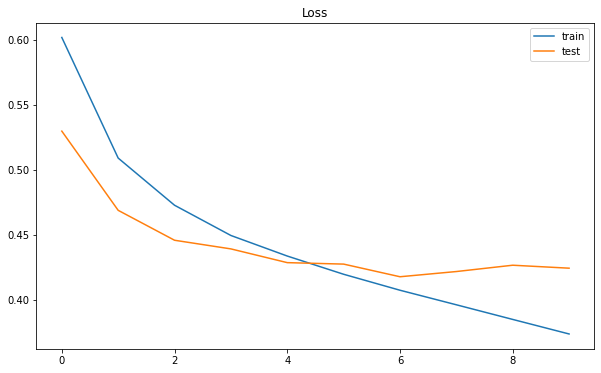

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Loss')
_=axs.axvline(x=early_stopping,color='r')
sns.lineplot(range(len(train_loss)), train_loss, label='train')
sns.lineplot(range(len(val_loss)), val_loss, label='test')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


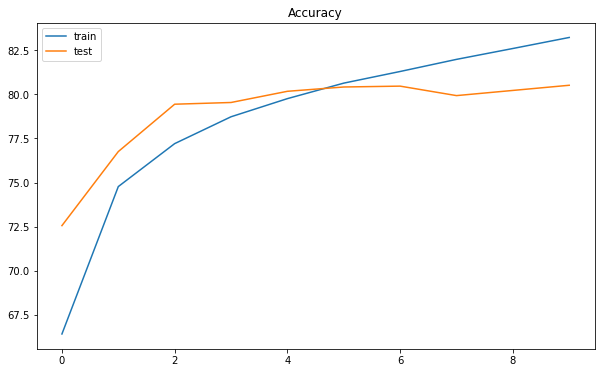

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Accuracy')
sns.lineplot(range(len(train_acc)), train_acc, label='train')
sns.lineplot(range(len(val_acc)), val_acc, label='test')

## ***Step 6***: Evaluate the test dataset

Find the accuracy of test dataset, using the same code as the validation evaluation before.

In [ ]:
model.eval()
test_h = model.init_hidden(batch_size)

with torch.no_grad():
  test_acc = list()
  for idx, batch in enumerate(tqdm(test_iter)):
    if model.cell_type == 'LSTM':
      test_h = tuple([e.data for e in test_h])
    elif model.cell_type == 'GRU':
      test_h.detach_()
      test_h = test_h.detach()

    text = batch.Text
    target = batch.Label
    target = target.type(torch.LongTensor)
    text = text.to(device)
    target = target.to(device)

    if text.shape[0] != batch_size:
      continue

    prediction, test_h = model(text, test_h)
    
    pred = torch.round(prediction.squeeze())
    num_corrects = (pred == target).float().sum()
    acc = 100.0 * num_corrects / len(batch)

    test_acc.append(acc.item())

print(f'Test Accuracy: {np.mean(test_acc): .2f}%')


Test Accuracy:  81.10%


Find the predictions for the test dataset (not manually as before), in order to use it for classification report and the Roc Curve. My previous implementation doesn't helped me very much to use classification report and Roc Curve. However, I kept my implementation of test accuracy to compare my results with the results of classification report (and I realized that my test accuracy and the accuracy of classification report is the same, which is very encouraging).

In [ ]:
results_target = list()
results_true_label = list()

with torch.no_grad():
    for batch in tqdm(test_iter):
        for label in tqdm(batch.Label):
            results_true_label.append(label.item())
        for text in batch.Text:
            text = text.unsqueeze(0)
            res, _ = model(text, hidden=None)

            target = np.round(res.cpu().numpy())
            
            results_target.append(target[0])

In [ ]:
df_pred_labels = pd.DataFrame (results_target, columns = ['target'])
df_true_labels = pd.DataFrame(results_true_label, columns=['target'])

In [ ]:
df_pred_labels['target'] = list(map(int, results_target))
df_true_labels['target'] = list(map(int, results_true_label))

In [ ]:
print(classification_report(df_true_labels,df_pred_labels))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1219
           1       0.81      0.81      0.81      1281

    accuracy                           0.81      2500
   macro avg       0.81      0.81      0.81      2500
weighted avg       0.81      0.81      0.81      2500



## ***Step 7***: Plot Roc Curve

**Roc Curve** tells us how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis. From theory of Machine Learning Lectures, we learned that false positive fraction = FP/(FP+TN) and true positive fraction = TP/(TP+FN). We notice that AUC is 0.81, which means there is 81% chance that model will be able to distinguish between positive and negative class. As you can see the Roc Curve isn't so smooth as it used to be to previous Projects. It might means that my model can only provide discrete predictions, rather than a continuous score (maybe the few epochs is responsible for it).

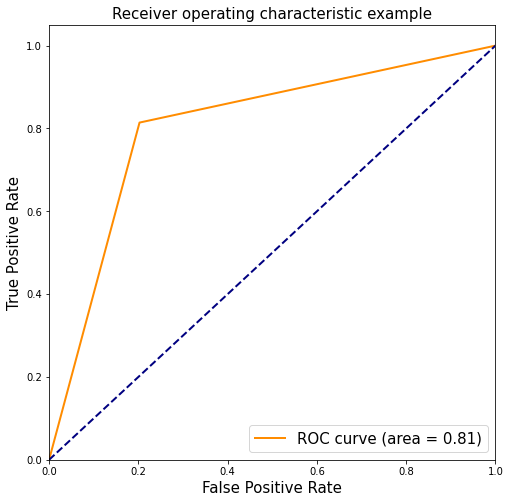

In [ ]:
# Convert tensors to numpy arrays after we pass them to cpu.
df = df_pred_labels.values.tolist()
df = np.array(df)

y = df_true_labels.values.tolist()
y = np.array(y)

# Label binarization and store num of classes.
y_test = label_binarize(y, classes=[0, 1])
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], df[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver operating characteristic example',fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.show()

## ***Step 8***: Summaries and Observations

I would like to mention to some of my experiments and the results that they gave me:
- First of all I had faced a big problem of overfitting and it wasn't something that I overcome very easily. In the beginning, I experiment with various values of these hyparameters:
  - ***Learning rate***, whose I kept the optimal, for me, value of 2e-3.
  - ***Dropout layers*** before, between and after LSTM/GRU layers with propabilities from 0.1 to even 0.9! I end up with propabilities of 0.2 and 0.3, but in the end the better score is without any dropout at all.
  - ***Weight_decay*** in Adam optimizer, which doesn't helped me very much
  - ***Dataset's size*** , whole or the half of it
  - ***Number of layers***, from 2 to 8 layers, but I noticed that as much as more layers I gave to the model, the more overfitting it happened. So I decided to stay at 2 layers. 
  - ***Number of epochs***. I started with fewer epochs (eg 5) and I end up to 10, since it wasn't improve the performance the more epochs I gave.
  - ***Hidden size***, from 32 to 1024, but 128 seems to give the better results.
  - ***Batch_size***, from 32 to 2048, but I kept the 2048 because it gives me good results with less time.  When I tried with lower values of batch size the gap between train and valid loss increased, since the lower the batch size is the faster and (specialized) the model was learning in train data.
  - ***Dimensions of Glove Pretrained Word Embeddings*** size with values of 25, 50, 100, 200
  - ***Gradient clipping*** with values from 2 to 5.
  
- As I experimented with these different values, I couldn't overcome overfitting and I couldn't understand the reason that even if I tried so many different values of hyparameters, nothing changed. Overfitting started from the first epoch and as the epochs increased, the train and validation loss diverged more and more. I tried to changed the percentages of the train test split, and give more data to valid dataset and less in train dataset, but there wasn't big difference in results. So even if I had good scores of 0.78  in test set, I wasn't satisfied.

- So, after several hours, days and weeks of experimentation, I realized that maybe my model is complex enough for the given dataset. If we observed the previous Projects, for the same dataset and a simple Logistic Regression, we had a test score of 0.80 and without even give a serious effort! So I decided to simplify my model as much as I could, see the results and then I increased the complexity slowly. I started with hidden size of 16, one layer and a non bidirectional model and I increased the value of them until I observed that train and validation loss converged! It was a very big relief that I could finally overcome overfitting.

- As you can see, the learning curves isn't the smoothest curves that you have ever seen (in the previous Projects were very smoother), but you can't say that they diverge anymore (at some point). It is a big improvement!

- After I dealed with overfitting, the only thing lefted to experiment is the type of cells (LSTM or GRU) and select the best model. But before I comment about the results each had, lets see some useful informations (from lectures):
  - Concerning the LSTM cell, we knew that maintains a cell state that is read from and written to. There are 4 gates that regulate the reading, writing, and outputting values to and from the cell state, dependent upon the input and cell state values. The first gate determines what the hidden state forgets. The next gate is responsible for determining what part of the cell state is written to. The third gate decides the contents that are written. Finally, the last gate reads from the cell state to produce an output.
  - On the other hand, GRU cell is similar to the LSTM cell but with a few important differences. First, there is no hidden state. The cell state adopts the functionality of the hidden state from the LSTM cell design. Next, the processes of determining what the cell states forgets and what part of the cell state is written to are consolidated into a single gate. Only the portion of the cell state that has been erased is written to. Finally, the entire cell state is given as an output. This is different from the LSTM cell which chooses what to read from the cell state to produce an output. All of these changes together provides a simpler design with less parameters than the LSTM. Less parameters, however, may come at the cost of decreased accuracy.
- So, we proved that LSTM is more complicated than GRU in general. This means that I expected to see better scores in LSTM than GRU. Despite having fewer parameters, the GRU model was able to achieve a lower loss after 5 epochs (~0.40). The LSTM model displays much greater volatility throughout its gradient descent compared to the GRU model. This may be due to the fact that there are more gates for the gradients to flow through, causing steady progress to be more difficult to maintain after some epochs. Additionally, the GRU model was able to train the data faster than the LSTM model. LSTM was able to achieve a loss of ~0.43 after 7 epochs. 
- The test score that (bi)LSTM gave me is 0.80 in contrast to (bi)GRU test score of 0.81. According to the theory, this is something we didn't expect to happen. However, I think that the GRU gives better results because is less complicated than the LSTM, and the dataset we gave to train them is much "easier" than we thought.
- Although the learning curves of LSTM seemed to me much more smooth than GRU's and they converge much more, I decided to don't take it so seriously and let it affect my decision. I focused more in the fact that GRU gives me similar results as LSTM and in less time (almost half) (and resources)! So this is why I decide the GRU as the best model.
- However, I would like to show you the learning curves that LSTM gave me (with the same parameters) in the picture below, to see what I was talking about. 

![alt text](https://drive.google.com/uc?id=1z56PJAXbTZs4_Z1k4MF_h3qpkhqRS9g0)

## ***Step 9***: Compare the results with the previous Project

If we look at the previous Project, we will see that I selected the deep Feed Forward Neural Network with TF-IDF (of 1000 dimensions) and 4 hidden layers, as the best model. This was gave me a score of 0.79 with minimun loss of ~0.45. My biGRU model gave me score of 0.81 with loss of ~0.40 and my biLSTM model gave me score of 0.80 with loss of ~0.43. Maybe the score and loss don't differ so much, but I think it is an improvement, which is something that we expected. If we look more carefully, we will see that the Feed Forward Neural Network give us these results in 50 epochs, in contrast to biGRU that give us this results in just 10 epochs! So we understand that this is a big improvement! Let's see in what maybe this improvement is due to:

- ***Feed-forward Neural Network*** allow signals to travel one way only: from input to output (inputs are processed only in the forward direction). There are no feedback (loops) and the output of any layer does not affect that same layer. Feed-forward models tend to be straightforward networks that associate inputs with outputs. They are extensively used in pattern recognition. Feed Forward Neural Networks can be used to solve problems related to:

    - *Tabular data*
    - *Image data*
    - *Text data*

  One common drawback of FFNN is that it cannot capture sequential information in the input data which is required for dealing with sequence data.

- On the other hand, ***RNN Networks*** can have signals traveling in both directions by introducing loops in the network. RNN networks are powerful and can get extremely complicated. Computations derived from earlier input are fed back into the network, which gives them a kind of memory. RNN networks are dynamic; their 'state' is changing continuously until they reach an equilibrium point. They remain at the equilibrium point until the input changes and a new equilibrium needs to be found. As we already understand, RNN has a recurrent connection on the hidden state. This looping constraint ensures that sequential information is captured in the input data. We can use recurrent neural networks to solve the problems related to:

    - *Time Series data*
    - *Text data*
    - *Audio data*

  One of the most important advantage of RNNs is that they captures the sequential information present in the input data i.e. dependency between the words in the text while making predictions. So, if we had a sentence the output of each word at each time step depends not only on the current word but also on the previous words. For this reason we understand why both biLSTM and biGRU are better than the FFNN of the previous task.

 